# Notebook Setup

## Naive Model Imports

In [6]:
!pip install scikit-learn==0.21.2
!pip install bioinfokit

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from keras import initializers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Model Optimization Imports

In [8]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Further Experiment Imports

In [9]:
from sklearn.decomposition import PCA
from bioinfokit.visuz import cluster

## Metadata Dataset

In [10]:
btc_meta = pd.read_csv('Bitcoin-Metadata.csv')
btc_meta = btc_meta.drop(['SNo', 'Name', 'Symbol', 'Date'], axis = 1)

In [11]:
btc_meta.head()

,High,Low,Open,Close,Volume,Marketcap,Day_Diff,Rel_Close,HL_Ratio,Rel_High,Rel_Low,SMA7,SMA30,SMA60,SMA90,SMA200,CMA,EMA1,EMA2,EMA3,EMA4,EMA5,EMA6,EMA7,EMA8,EMA9,EMA10,Close2
0,425.899994,395.190002,406.410004,420.200012,0.0,5.038818e+09,13.790009,0.033931,1.077709,1.013565,0.940481,362.025709,238.061666,184.322333,164.856867,132.887528,132.887528,294.314803,347.211757,373.225716,388.494797,398.657691,406.017945,411.524047,415.587278,418.427258,420.200012,417.950012
1,437.890015,396.109985,419.410004,417.950012,0.0,5.013561e+09,-1.459991,-0.003481,1.105476,1.047709,0.947745,373.431427,247.241667,189.092833,168.239645,134.254578,134.305749,306.678324,361.359408,386.643005,400.276883,408.303852,413.177185,416.022223,417.477465,417.997737,417.950012,440.220001
2,450.260010,415.570007,417.279999,440.220001,0.0,5.282849e+09,22.940002,0.054975,1.083476,1.022807,0.944005,387.875715,257.040667,194.235500,171.869867,135.760678,135.820176,320.032492,377.131527,402.716104,416.254131,424.261927,429.402875,432.960668,435.671494,437.997775,440.220001,492.109985
3,500.579987,440.239990,440.959991,492.109985,0.0,5.907842e+09,51.149994,0.115997,1.137062,1.017212,0.894597,411.517142,268.245666,200.246166,176.015533,137.636278,137.575298,337.240241,400.127218,429.534268,446.596472,458.185956,467.027141,474.365190,480.822287,486.698764,492.109985,703.559998
4,703.780029,494.940002,496.579987,703.559998,0.0,8.449070e+09,206.980011,0.416811,1.421950,1.000313,0.703479,463.105713,285.950333,209.811333,182.486145,140.628028,140.349733,373.872217,460.813774,511.741987,549.381882,580.872977,608.946855,634.801555,659.012455,681.873874,703.559998,584.609985


In [12]:
def f(x):
  if (x['Close2'] > x['Close']):
    return 1
  else:
    return 0

btc_meta_c = btc_meta.copy()
btc_meta_c['Direction'] = btc_meta_c.apply(f, axis = 1)
btc_meta_c = btc_meta_c.drop(btc_meta_c.columns[-2], axis = 1)

btc_meta_r = btc_meta

## Historical Dataset

In [13]:
btc_hist = pd.read_csv('Bitcoin-Historical.csv')
btc_hist = btc_hist.drop(['SNo', 'Date'], axis = 1)

In [14]:
btc_hist.head()

,Close1,Close2,Close3,Close4,Close5,Close6,Close7,Close8,Close9,Close10,Close11,Close12,Close13,Close14,Close15,Close16,Close17,Close18,Close19,Close20,Close21,Close22,Close23,Close24,Close25,Close26,Close27,Close28,Close29,Close30,Close31,Close32,Close33,Close34,Close35,Close36,Close37,Close38,Close39,Close40,...,Close52,Close53,Close54,Close55,Close56,Close57,Close58,Close59,Close60,Close61,Close62,Close63,Close64,Close65,Close66,Close67,Close68,Close69,Close70,Close71,Close72,Close73,Close74,Close75,Close76,Close77,Close78,Close79,Close80,Close81,Close82,Close83,Close84,Close85,Close86,Close87,Close88,Close89,Close90,Close91
0,144.539993,139.000000,116.989998,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,117.199997,115.242996,115.000000,117.980003,111.500000,114.220001,118.760002,123.014999,123.498001,121.989998,122.000000,122.879997,123.889000,126.699997,133.199997,131.979996,133.479996,129.744995,129.000000,132.300003,128.798996,129.000000,129.300003,122.292000,122.222000,121.419998,121.650002,118.000000,111.500000,...,108.250000,110.150002,109.500000,108.300003,107.599998,102.737000,103.949997,104.000000,101.436996,94.649200,94.994003,96.613998,88.050003,90.134003,77.529999,80.525803,68.431000,70.277298,74.561096,76.515999,76.694000,86.760002,88.980003,93.594902,98.133904,94.691299,98.400200,97.450798,98.500000,90.580002,92.169998,89.390099,90.757301,91.610001,95.558502,94.510002,96.900002,96.020203,94.115997,99.755997
1,139.000000,116.989998,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,117.199997,115.242996,115.000000,117.980003,111.500000,114.220001,118.760002,123.014999,123.498001,121.989998,122.000000,122.879997,123.889000,126.699997,133.199997,131.979996,133.479996,129.744995,129.000000,132.300003,128.798996,129.000000,129.300003,122.292000,122.222000,121.419998,121.650002,118.000000,111.500000,108.300003,...,110.150002,109.500000,108.300003,107.599998,102.737000,103.949997,104.000000,101.436996,94.649200,94.994003,96.613998,88.050003,90.134003,77.529999,80.525803,68.431000,70.277298,74.561096,76.515999,76.694000,86.760002,88.980003,93.594902,98.133904,94.691299,98.400200,97.450798,98.500000,90.580002,92.169998,89.390099,90.757301,91.610001,95.558502,94.510002,96.900002,96.020203,94.115997,99.755997,101.199997
2,116.989998,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,117.199997,115.242996,115.000000,117.980003,111.500000,114.220001,118.760002,123.014999,123.498001,121.989998,122.000000,122.879997,123.889000,126.699997,133.199997,131.979996,133.479996,129.744995,129.000000,132.300003,128.798996,129.000000,129.300003,122.292000,122.222000,121.419998,121.650002,118.000000,111.500000,108.300003,100.000000,...,109.500000,108.300003,107.599998,102.737000,103.949997,104.000000,101.436996,94.649200,94.994003,96.613998,88.050003,90.134003,77.529999,80.525803,68.431000,70.277298,74.561096,76.515999,76.694000,86.760002,88.980003,93.594902,98.133904,94.691299,98.400200,97.450798,98.500000,90.580002,92.169998,89.390099,90.757301,91.610001,95.558502,94.510002,96.900002,96.020203,94.115997,99.755997,101.199997,107.989998
3,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,117.199997,115.242996,115.000000,117.980003,111.500000,114.220001,118.760002,123.014999,123.498001,121.989998,122.000000,122.879997,123.889000,126.699997,133.199997,131.979996,133.479996,129.744995,129.000000,132.300003,128.798996,129.000000,129.300003,122.292000,122.222000,121.419998,121.650002,118.000000,111.500000,108.300003,100.000000,106.349998,...,108.300003,107.599998,102.737000,103.949997,104.000000,101.436996,94.649200,94.994003,96.613998,88.050003,90.134003,77.529999,80.525803,68.431000,70.277298,74.561096,76.515999,76.694000,86.760002,88.980003,93.594902,98.133904,94.691299,98.400200,97.450798,98.500000,90.580002,92.169998,89.390099,90.757301,91.610001,95.558502,94.510002,96.900002,96.020203,9

In [15]:
def f(x):
  if (x['Close91'] > x['Close90']):
    return 1
  else:
    return 0

btc_hist_c = btc_hist.copy()
btc_hist_c['Direction'] = btc_hist_c.apply(f, axis = 1)
btc_hist_c = btc_hist_c.drop(btc_hist_c.columns[-2], axis = 1)

btc_hist_r = btc_hist

# Naive Approach - Classification (Metadata)

In [16]:
X = btc_meta_c.iloc[:, :-1]
y = btc_meta_c.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [17]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Support Vector Machine

In [18]:
clf = SVC(kernel = 'linear', gamma = 'auto', cache_size = 7000, max_iter = 1e7)
clf = clf.fit(X_train, y_train)

In [19]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
svm_metrics = (accuracy_score(y_test, y_pred), 
               f1_score(y_test, y_pred, average = 'binary'))

## Random Forest

In [20]:
clf = RandomForestClassifier(n_estimators = 50, criterion = 'entropy')
clf = clf.fit(X_train, y_train)

In [21]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
rf_metrics = (accuracy_score(y_test, y_pred), 
               f1_score(y_test, y_pred, average = 'binary'))

## Neural Network

In [22]:
clf = Sequential()
clf.add(Dense(units = 50, kernel_initializer = 'random_uniform', 
                     activation = 'relu', input_dim = X_train.shape[1]))
clf.add(Dropout(0.1))
clf.add(Dense(units = 100, kernel_initializer = 'random_uniform',
                     activation = 'relu'))
clf.add(Dropout(0.5))
clf.add(Dense(units = 50, kernel_initializer = 'random_uniform',
                     activation = 'relu'))
clf.add(Dropout(0.1))
clf.add(Dense(units = 1, activation = 'sigmoid'))

clf.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
clf.fit(X_train, y_train, batch_size = (X_train.shape[0] // 10), epochs = 1000, verbose = 0)

In [23]:
y_pred = clf.predict_classes(X_test)
cm = confusion_matrix(y_test, y_pred)
nn_metrics = (accuracy_score(y_test, y_pred), 
               f1_score(y_test, y_pred, average = 'binary'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## Evaluation

In [24]:
idx_rows = ['Support Vector Machine', 'Random Forest', 'Neural Network']
data = {
    'Accuracy':  [svm_metrics[0], rf_metrics[0], nn_metrics[0]],
    'F-1 Score': [svm_metrics[1], rf_metrics[1], nn_metrics[1]]
}
results = pd.DataFrame(data, columns = ['Accuracy','F-1 Score'], index = idx_rows)
results

,Accuracy,F-1 Score
Support Vector Machine,0.513514,0.678571
Random Forest,0.543544,0.583562
Neural Network,0.543544,0.610256


# Naive Approach - Regression (Metadata)

In [25]:
X = btc_meta_r.iloc[:, :-1]
y = btc_meta_r.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [26]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Support Vector Machine

In [27]:
reg = SVR(kernel = 'linear', gamma = 'auto', cache_size = 7000, max_iter = 1e7)
reg = reg.fit(X_train, y_train)

In [28]:
y_pred = reg.predict(X_test)
svm_metrics = (mean_absolute_error(y_test, y_pred), 
               r2_score(y_test, y_pred))

## Random Forest

In [29]:
reg = RandomForestRegressor(n_estimators = 50, criterion = 'mse')
reg = reg.fit(X_train, y_train)

In [30]:
y_pred = reg.predict(X_test)
rf_metrics = (mean_absolute_error(y_test, y_pred), 
              r2_score(y_test, y_pred))

## Neural Network

In [31]:
reg = Sequential()
reg.add(Dense(units = 50, kernel_initializer = 'random_uniform', 
                     activation = 'relu', input_dim = X_train.shape[1]))
reg.add(Dropout(0.1))
reg.add(Dense(units = 100, kernel_initializer = 'random_uniform',
                     activation = 'relu'))
reg.add(Dropout(0.5))
clf.add(Dense(units = 50, kernel_initializer = 'random_uniform',
                     activation = 'relu'))
reg.add(Dropout(0.1))
reg.add(Dense(units = 1))

reg.compile(optimizer = 'adam', loss = 'mean_absolute_error')
reg.fit(X_train, y_train, batch_size = (X_train.shape[0] // 10), epochs = 1000, verbose = 0)

In [32]:
y_pred = reg.predict(X_test)
nn_metrics = (mean_absolute_error(y_test, y_pred), 
              r2_score(y_test, y_pred))

## Evaluation

In [33]:
idx_rows = ['Support Vector Machine', 'Random Forest', 'Neural Network']
data = {
    'MAE':  [svm_metrics[0], rf_metrics[0], nn_metrics[0]],
    'R2 Score': [svm_metrics[1], rf_metrics[1], nn_metrics[1]]
}
results = pd.DataFrame(data, columns = ['MAE','R2 Score'], index = idx_rows)
results

,MAE,R2 Score
Support Vector Machine,287.231899,0.988320
Random Forest,211.994306,0.993369
Neural Network,229.372334,0.993759


# Naive Approach - Classification (Historical)

In [34]:
X = btc_hist_c.iloc[:, :-1]
y = btc_hist_c.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [35]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Support Vector Machine

In [36]:
clf = SVC(kernel = 'linear', gamma = 'auto', cache_size = 7000, max_iter = 1e7)
clf = clf.fit(X_train, y_train)

In [37]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
svm_metrics = (accuracy_score(y_test, y_pred), 
               f1_score(y_test, y_pred, average = 'binary'))

## Random Forest

In [38]:
clf = RandomForestClassifier(n_estimators = 50, criterion = 'entropy')
clf = clf.fit(X_train, y_train)

In [39]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
rf_metrics = (accuracy_score(y_test, y_pred), 
               f1_score(y_test, y_pred, average = 'binary'))

## Neural Network

In [40]:
clf = Sequential()
clf.add(Dense(units = 50, kernel_initializer = 'random_uniform', 
                     activation = 'relu', input_dim = X_train.shape[1]))
clf.add(Dropout(0.1))
clf.add(Dense(units = 100, kernel_initializer = 'random_uniform',
                     activation = 'relu'))
clf.add(Dropout(0.5))
clf.add(Dense(units = 50, kernel_initializer = 'random_uniform',
                     activation = 'relu'))
clf.add(Dropout(0.1))
clf.add(Dense(units = 1, activation = 'sigmoid'))

clf.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
clf.fit(X_train, y_train, batch_size = (X_train.shape[0] // 10), epochs = 1000, verbose = 0)

In [41]:
y_pred = clf.predict_classes(X_test)
cm = confusion_matrix(y_test, y_pred)
nn_metrics = (accuracy_score(y_test, y_pred), 
               f1_score(y_test, y_pred, average = 'binary'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## Evaluation

In [42]:
idx_rows = ['Support Vector Machine', 'Random Forest', 'Neural Network']
data = {
    'Accuracy':  [svm_metrics[0], rf_metrics[0], nn_metrics[0]],
    'F-1 Score': [svm_metrics[1], rf_metrics[1], nn_metrics[1]]
}
results = pd.DataFrame(data, columns = ['Accuracy','F-1 Score'], index = idx_rows)
results

,Accuracy,F-1 Score
Support Vector Machine,0.518038,0.667331
Random Forest,0.509380,0.554974
Neural Network,0.490620,0.615887


# Naive Approach - Regression (Historical)

In [43]:
X = btc_hist_r.iloc[:, :-1]
y = btc_hist_r.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [44]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Support Vector Machine

In [45]:
reg = SVR(kernel = 'linear', gamma = 'auto', cache_size = 7000, max_iter = 1e7)
reg = reg.fit(X_train, y_train)

In [46]:
y_pred = reg.predict(X_test)
svm_metrics = (mean_absolute_error(y_test, y_pred), 
               r2_score(y_test, y_pred))

## Random Forest

In [47]:
reg = RandomForestRegressor(n_estimators = 50, criterion = 'mse')
reg = reg.fit(X_train, y_train)

In [48]:
y_pred = reg.predict(X_test)
rf_metrics = (mean_absolute_error(y_test, y_pred), 
              r2_score(y_test, y_pred))

## Neural Network

In [49]:
reg = Sequential()
reg.add(Dense(units = 50, kernel_initializer = 'random_uniform', 
                     activation = 'relu', input_dim = X_train.shape[1]))
reg.add(Dropout(0.1))
reg.add(Dense(units = 100, kernel_initializer = 'random_uniform',
                     activation = 'relu'))
reg.add(Dropout(0.5))
clf.add(Dense(units = 50, kernel_initializer = 'random_uniform',
                     activation = 'relu'))
reg.add(Dropout(0.1))
reg.add(Dense(units = 1))

reg.compile(optimizer = 'adam', loss = 'mean_absolute_error')
reg.fit(X_train, y_train, batch_size = (X_train.shape[0] // 10), epochs = 1000, verbose = 0)

In [50]:
y_pred = reg.predict(X_test)
nn_metrics = (mean_absolute_error(y_test, y_pred), 
              r2_score(y_test, y_pred))

## Evaluation

In [51]:
idx_rows = ['Support Vector Machine', 'Random Forest', 'Neural Network']
data = {
    'MAE':  [svm_metrics[0], rf_metrics[0], nn_metrics[0]],
    'R2 Score': [svm_metrics[1], rf_metrics[1], nn_metrics[1]]
}
results = pd.DataFrame(data, columns = ['MAE','R2 Score'], index = idx_rows)
results

,MAE,R2 Score
Support Vector Machine,521.708092,0.965217
Random Forest,159.783317,0.996039
Neural Network,234.502067,0.994371


# Optimization

Now that we have baseline metric scores for a range of problems that we have been exploring, we can begin to optimise these naive models in order to test their limit. 

From the previous sections, we can see that all baseline models demonstrated some degree of competency. There was, however, one exception - the classification models that utilised historical closing price data to predict an upward or downward movement in next-day price. Here, no model could predict much above an accuracy 50% (the approximate random guessing percentage), so we do not proceed with optimising models to do so as it seems to be a problem that cannot be solved by such naive models. This makes sense logically - as naive models do not have a sense of the sequence of data, and there is no standard pattern in upward-downward price movement between particular days in the span of previous 90 days. 

We will also abstain from optimising the regression models trained on the metadata dataset - for this, the optimal models were found to be the Random Forest and Neural Network models. Hence, should we wish to optimise this model in the future, we can simply either of the optimisation techniques demonstrated in this section, as they cover each of these respectively.

## Classification (Metadata) - Neural Network

The baseline Neural Network model outperformed the other models for this problem - hence, we can attempt to create an optized model for this.

In [52]:
X = btc_meta_c.iloc[:, :-1]
y = btc_meta_c.iloc[:, -1]
X = SelectKBest(score_func = f_classif, k = 10).fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [53]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [54]:
def build_classifier(optimizer = 'adam'):
    clf = Sequential()
    clf.add(Dense(units = 50, kernel_initializer = 'random_uniform', 
                        activation = 'relu', input_dim = X_train.shape[1]))
    clf.add(Dropout(0.1))
    clf.add(Dense(units = 100, kernel_initializer = 'random_uniform',
                        activation = 'relu'))
    clf.add(Dropout(0.5))
    clf.add(Dense(units = 50, kernel_initializer = 'random_uniform',
                        activation = 'relu'))
    clf.add(Dropout(0.1))
    clf.add(Dense(units = 1, activation = 'sigmoid'))
    clf.compile(optimizer = optimizer, loss = 'binary_crossentropy', 
                metrics = ['accuracy'])
    return clf

clf = KerasClassifier(build_fn = build_classifier, verbose = 0)

batch_size = [10, 50]
epochs = [100, 1000, 5000]
optimizers = ['adam', 'adagrad', 'rmsprop']
es = EarlyStopping(monitor = 'accuracy', patience = 25)
callbacks = [es]

grid = {'epochs': epochs,
        'batch_size': batch_size,
        'optimizer': optimizers,
        'callbacks': callbacks}
validator = GridSearchCV(clf, param_grid = grid, cv = 5,
                         scoring = 'accuracy', n_jobs = 1, verbose = 0)
validator.fit(X_train, y_train)
clf = validator.best_estimator_.model

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [55]:
y_pred = clf.predict_classes(X_test)
cm = confusion_matrix(y_test, y_pred)
nn_metrics = (accuracy_score(y_test, y_pred), 
               f1_score(y_test, y_pred, average = 'binary'))
nn_metrics

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(0.5570570570570571, 0.7155255544840887)

In [56]:
clf_metadata_opt = clf

## Regression (Historical) - Random Forest

The baseline Random Forest model outperformed the other trialled models for this problem - hence, we can attempt to create an optized model for this.

In [153]:
X = btc_hist_r.iloc[:, :-1]
y = btc_hist_r.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [154]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [155]:
estimators = [50, 100, 200]
depth = [None, 25, 50]
features = ['auto', 'sqrt']

grid = {'n_estimators': estimators,
        'max_depth': depth,
        'max_features': features}
reg = RandomForestRegressor()
validator = GridSearchCV(estimator = reg, param_grid = grid, 
                          cv = 5, n_jobs = 1, verbose = 0)
validator.fit(X_train, y_train)
reg = validator.best_estimator_
reg_params = validator.best_params_

In [156]:
y_pred = reg.predict(X_test)
rf_metrics = (mean_absolute_error(y_test, y_pred), 
              r2_score(y_test, y_pred))
rf_metrics

(160.85777114612387, 0.9964980615048042)

In [157]:
reg_historical_opt = reg

# Further Experiments

## Reducing the N-Day Timeline

Thus far, we have used the previous 90 days to predict the present day closing price of bitcoin. We can now test how our optimised model does when using a varying number of days to predict the present day closing price - 3 days, 10 days and 30 days. We will not change any aspect of the optimised model besides the number of input features it takes.

In [158]:
print(reg_params)

{'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 50}


In [159]:
X = btc_hist_r.iloc[:, :-1]
y = btc_hist_r.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [160]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [161]:
metrics = []
days = [3, 10, 30, 90]

for i in days:
  X_train = X_train[:, -i:]
  X_test = X_test[:, -i:]

  reg = RandomForestRegressor(n_estimators = 200, max_depth = None,
                              max_features = 'sqrt')
  reg = reg.fit(X_train, y_train)

  y_pred = reg.predict(X_test)
  m = (mean_absolute_error(y_test, y_pred), 
              r2_score(y_test, y_pred))
  metrics.append(m)

In [162]:
idx_rows = ['3 Days', '10 Days', '30 Days', '90 Days']
data = {
    'MAE':  [metrics[0][0], metrics[1][0], metrics[2][0], metrics[3][0]],
    'R2 Score': [metrics[0][1], metrics[1][1], metrics[2][1], metrics[3][1]]
}
results = pd.DataFrame(data, columns = ['MAE','R2 Score'], index = idx_rows)
results

,MAE,R2 Score
3 Days,177.979900,0.995668
10 Days,181.998261,0.995152
30 Days,176.394733,0.995825
90 Days,179.174810,0.995381


## Downscaling the Model 

Our current price prediction model uses 90 days of historical prices to predict the next-day price, creating a memory-intensive operation given both the number of rows and columns in the training dataste. Furthermore, we know that days far before the next day are likely to be less significant that days closer to it. As a result, we can apply some dimensionality reduction techniques and see whether or not our optimised regression model still maintains its performance.

In [163]:
X = btc_hist_r.iloc[:, :-1]
y = btc_hist_r.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [164]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

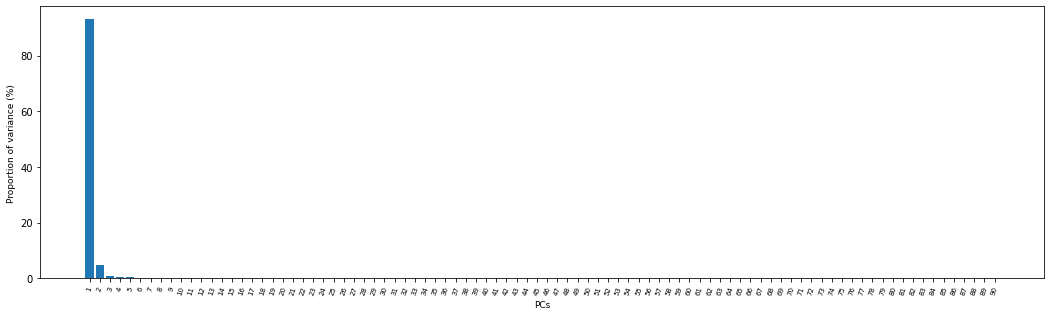

In [165]:
pca = PCA()
pca = pca.fit(X_train)
var = pca.explained_variance_
num = pca.n_features_
names = [str(i) for i in list(range(1, num + 1))]
cluster.screeplot(obj = [names, pca.explained_variance_ratio_], dim = (18, 5), show = True)

In [166]:
pca = PCA(n_components = 5)
pca = pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [167]:
reg = RandomForestRegressor(n_estimators = 200, max_depth = None,
                              max_features = 'sqrt')
reg = reg.fit(X_train, y_train)

In [168]:
y_pred = reg.predict(X_test)
rf_metrics = (mean_absolute_error(y_test, y_pred), 
              r2_score(y_test, y_pred))
rf_metrics

(165.74214781713158, 0.9963804351128439)

## Extending to Other Cryptocurrencies

So far, our experiments have been limited to Bitcoin. We can now test and see whether or not our closing price prediction model works well for other crypotcurrencies, and if not, whether its architecture works well if trained and fitted on the data for another cryptocurrency.

In [169]:
eth_hist = pd.read_csv('Ethereum-Historical.csv')
eth_hist = eth_hist.drop(['SNo', 'Date'], axis = 1)

In [170]:
eth_hist_r = eth_hist
eth_hist.head()

,Close1,Close2,Close3,Close4,Close5,Close6,Close7,Close8,Close9,Close10,Close11,Close12,Close13,Close14,Close15,Close16,Close17,Close18,Close19,Close20,Close21,Close22,Close23,Close24,Close25,Close26,Close27,Close28,Close29,Close30,Close31,Close32,Close33,Close34,Close35,Close36,Close37,Close38,Close39,Close40,...,Close52,Close53,Close54,Close55,Close56,Close57,Close58,Close59,Close60,Close61,Close62,Close63,Close64,Close65,Close66,Close67,Close68,Close69,Close70,Close71,Close72,Close73,Close74,Close75,Close76,Close77,Close78,Close79,Close80,Close81,Close82,Close83,Close84,Close85,Close86,Close87,Close88,Close89,Close90,Close91
0,0.753325,0.701897,0.708448,1.06786,1.21744,1.82767,1.82787,1.68890,1.56603,1.20361,1.08705,1.25886,1.46492,1.39529,1.37923,1.35259,1.23127,1.14019,1.15998,1.14770,1.19138,1.18255,1.31927,1.35824,1.35161,1.29479,1.26493,1.27441,1.33881,1.29583,1.246650,1.242430,1.206510,1.165770,0.982978,1.038740,0.936003,0.875622,0.944410,0.907175,...,0.582886,0.661146,0.738644,0.690215,0.678574,0.687171,0.668379,0.628643,0.650645,0.609388,0.621716,0.650628,0.627857,0.634963,0.626030,0.607655,0.522968,0.561878,0.536495,0.547178,0.517734,0.489014,0.434829,0.447329,0.567702,0.539657,0.563590,0.616039,0.731317,0.869641,1.002480,1.206660,1.041220,0.916627,1.055670,0.989789,1.013360,0.899050,0.895637,0.926032
1,0.701897,0.708448,1.067860,1.21744,1.82767,1.82787,1.68890,1.56603,1.20361,1.08705,1.25886,1.46492,1.39529,1.37923,1.35259,1.23127,1.14019,1.15998,1.14770,1.19138,1.18255,1.31927,1.35824,1.35161,1.29479,1.26493,1.27441,1.33881,1.29583,1.24665,1.242430,1.206510,1.165770,0.982978,1.038740,0.936003,0.875622,0.944410,0.907175,0.874231,...,0.661146,0.738644,0.690215,0.678574,0.687171,0.668379,0.628643,0.650645,0.609388,0.621716,0.650628,0.627857,0.634963,0.626030,0.607655,0.522968,0.561878,0.536495,0.547178,0.517734,0.489014,0.434829,0.447329,0.567702,0.539657,0.563590,0.616039,0.731317,0.869641,1.002480,1.206660,1.041220,0.916627,1.055670,0.989789,1.013360,0.899050,0.895637,0.926032,0.927974
2,0.708448,1.067860,1.217440,1.82767,1.82787,1.68890,1.56603,1.20361,1.08705,1.25886,1.46492,1.39529,1.37923,1.35259,1.23127,1.14019,1.15998,1.14770,1.19138,1.18255,1.31927,1.35824,1.35161,1.29479,1.26493,1.27441,1.33881,1.29583,1.24665,1.24243,1.206510,1.165770,0.982978,1.038740,0.936003,0.875622,0.944410,0.907175,0.874231,0.853685,...,0.738644,0.690215,0.678574,0.687171,0.668379,0.628643,0.650645,0.609388,0.621716,0.650628,0.627857,0.634963,0.626030,0.607655,0.522968,0.561878,0.536495,0.547178,0.517734,0.489014,0.434829,0.447329,0.567702,0.539657,0.563590,0.616039,0.731317,0.869641,1.002480,1.206660,1.041220,0.916627,1.055670,0.989789,1.013360,0.899050,0.895637,0.926032,0.927974,1.027470
3,1.067860,1.217440,1.827670,1.82787,1.68890,1.56603,1.20361,1.08705,1.25886,1.46492,1.39529,1.37923,1.35259,1.23127,1.14019,1.15998,1.14770,1.19138,1.18255,1.31927,1.35824,1.35161,1.29479,1.26493,1.27441,1.33881,1.29583,1.24665,1.24243,1.20651,1.165770,0.982978,1.038740,0.936003,0.875622,0.944410,0.907175,0.874231,0.853685,0.882391,...,0.690215,0.678574,0.687171,0.668379,0.628643,0.650645,0.609388,0.621716,0.650628,0.627857,0.634963,0.626030,0.607655,0.522968,0.561878,0.536495,0.547178,0.517734,0.489014,0.434829,0.447329,0.567702,0.539657,0.563590,0.616039,0.731317,0.869641,1.002480,1.206660,1.041220,0.916627,1.055670,0.989789,1.013360,0.899050,0.895637,0.926032,0.927974,1.027470,0.999278
4,1.217440,1.827670,1.827870,1.68890,1.56603,1.20361,1.08705,1.25886,1.46492,1.39529,1.37923,1.35259,1.23127,1.14019,1.15998,1.14770,1.19138,1.18255,1.31927,1.35824,1.35161,1.29479,1.26493,1.27441,1.33881,1.29583,1.24665,1.24243,1.20651,1.16577,0.982978,1.038740,0.936003,0.875622,0.944410,0.907175,0.874231,0.853685,0.882391,0.938445,...,0.678574,0.687171,0.668379,0.628643,0.650645,0.609388,0.621716,0.650628,0.627857,0.634963,0.626030,0.607655,0.522968,0.561878,0.536495,0.547178,0.517734,0.489014,0.434829,0.447329,0.567702,0.539657,0.563590,0.616039,0.731317,0.86

### Existing Model

In [171]:
X = eth_hist_r.iloc[:, :-1]
y = eth_hist_r.iloc[:, -1]

In [172]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [173]:
y_pred = reg_historical_opt.predict(X)
rf_metrics = (mean_absolute_error(y, y_pred), 
              r2_score(y, y_pred))
rf_metrics

(5154.498708450041, -654.9813288259772)

### Existing Architecture

In [174]:
X = eth_hist_r.iloc[:, :-1]
y = eth_hist_r.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [175]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [176]:
reg = RandomForestRegressor(n_estimators = 200, max_depth = None,
                            max_features = 'sqrt')
reg = reg.fit(X_train, y_train)

In [177]:
y_pred = reg.predict(X_test)
rf_metrics = (mean_absolute_error(y_test, y_pred), 
              r2_score(y_test, y_pred))
rf_metrics

(11.87864444672022, 0.9937325653238789)